In [205]:
import random
import functools
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate


def integral(function, start, stop, discontinuities=[]):
    '''
    Return the integral of the function between start and stop.
    Optionally give a list of discontinuities where the function is not continuous to allow the integral to be calculated in parts.
    '''
    if len(discontinuities) > 0:
        res = 0
        for i in range(len(discontinuities) - 1):
            res += integrate.quad(function, discontinuities[i], discontinuities[i + 1])[0]
        return res
    else:
        return integrate.quad(function, start, stop)[0]

def integral_simps(x, y, start, stop):
    # get only the x, y values where x is between start and stop
    mask = (x >= start) & (x <= stop)
    x_in = np.array(x)[mask]
    y_in = np.array(y)[mask]

    return integrate.simpson(y=y_in, x=x_in)

In [2]:
def sample(function, start, stop, n=1000):
    x = np.linspace(start, stop, n)
    y = np.array([function(i) for i in x])
    return x, y

def functionalize(x, y):
    return lambda z : np.interp(z, x, y)

def discretize(function, start, stop, n=1000):
    x, y = sample(function, start, stop, n)
    return functionalize(x, y)

P2 strategy: "Always betting or calling when having a King; when having a Queen, checking if possible, otherwise calling with the probability of 1/3; when having a Jack, never calling and betting with the probability of 1/3." (https://en.wikipedia.org/wiki/Kuhn_poker)

* 1, raise: Never call.
* 1, check: Bet with probability 1/3.
* 2, raise: Call with probability 1/3.
* 2, check: Check.
* 3, raise: Call.
* 3, check: Bet.

In [3]:
def p2nashAction(card, call_cost):
    # call cost is 0 if p1 checked, 1 if raised.
    # return 0 if check/fold, 1 if call/raise
    match card, call_cost:
        case 1, 1:
            return 0
        case 1, 0:
            if random.random() < 1/3:
                return 1
            else:
                return 0
        case 2, 1:
            if random.random() < 1/3:
                return 1
            else:
                return 0
        case 2, 0:
            return 0
        case 3, 1:
            return 1
        case 3, 0:
            return 1

P1 strategy: "player one freely chooses the probability $\alpha \in [0, 1/3]$" with which they will bet when having a Jack (otherwise they check; if the other player bets, they should always fold). When having a King, they should bet with the probability of 
$3 \alpha$ (otherwise they check; if the other player bets, they should always call). They should always check when having a Queen, and if the other player bets after this check, they should call with the probability of 
$\alpha + 1/3$."

In [4]:
def p1nashAction(card, call_cost, alpha=0):
    # call cost is 0 if p1 checked, 1 if raised.
    # return 0 if check/fold, 1 if call/raise
    match card, call_cost:
        case 1, 1:
            return 0
        case 1, 0:
            if random.random() < alpha:
                return 1
            else:
                return 0
        case 2, 1:
            if random.random() < alpha + 1/3:
                return 1
            else:
                return 0
        case 2, 0:
            return 0
        case 3, 1:
            return 1
        case 3, 0:
            if random.random() < 3 * alpha:
                return 1
            else:
                return 0

In [5]:
def kuhn_p1EV(p1strategy, p2strategy, iters=1):
    # regular kuhn poker; each player is dealt 1 2 or 3, and the highest card wins
    # strategies should be functions of the form f(card, call_cost) -> 0 or 1 (0 is check/fold, 1 is call/raise)
    # return p1s average winnings per iter
    cards = [1, 2, 3]
    score = 0
    for i in range(iters):
        h1, h2 = random.sample(cards, k=2)
        p1action = p1strategy(h1, 0)
        p2action = p2strategy(h2, p1action)
        if p1action==0 and p2action == 1: # p1 checked, p2 bet
            p1action = p1strategy(h1, 1)
            if p1action == 1: # p1 calls
                if h1 > h2:
                    score += 2
                else:
                    score -= 2
            else: # p1 folds
                score -= 1
        elif p1action == 1 and p2action == 0: # p1 bet, p2 folded
            score += 1
        elif p1action == 1 and p2action == 1: # both bet
            if h1 > h2:
                score += 2
            else:
                score -= 2
        else: # both checked
            if h1 > h2:
                score += 1
            else:
                score -= 1
    return score/iters

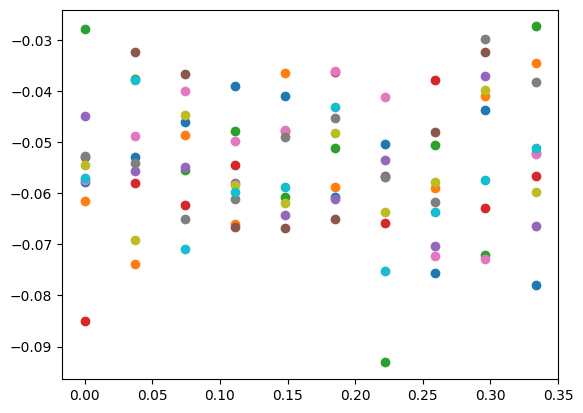

In [6]:
# show the ev for player 2 in some simulated games
fig = plt.figure()
evs = []
alphas = np.linspace(0, 1/3, 10)
for alpha in alphas:
    p1strategy = functools.partial(p1nashAction, alpha=alpha)
    for i in range(10):
        plt.scatter(alpha, kuhn_p1EV(p1nashAction, p2nashAction, 10000))

# should be scattered around -0.06 ish

## Continuous Kuhn poker

each player is dealt a real number from 0 to 1.
The player with the higher number wins. 

In [7]:
def continuous_kuhn_p1EV(p1strategy, p2strategy, iters=1):
    # continuous kuhn poker; each player is dealt real from [0, 1], and the highest value wins
    # strategies should be functions of the form f(card, call_cost) -> 0 or 1 (0 is check/fold, 1 is call/raise)
    # return p1s average winnings per iter
    score = 0
    for i in range(iters):
        h1, h2 = random.random(), random.random()
        p1action = p1strategy(h1, 0)
        p2action = p2strategy(h2, p1action)
        if p1action==0 and p2action == 1: # p1 checked, p2 bet
            p1action = p1strategy(h1, 1)
            if p1action == 1: # p1 calls
                if h1 > h2:
                    score += 2
                else:
                    score -= 2
            else: # p1 folds
                score -= 1
        elif p1action == 1 and p2action == 0: # p1 bet, p2 folded
            score += 1
        elif p1action == 1 and p2action == 1: # both bet
            if h1 > h2:
                score += 2
            else:
                score -= 2
        else: # both checked
            if h1 > h2:
                score += 1
            else:
                score -= 1
    return score/iters

Imagine we know the opponent's frequencies as the functions $b(x)$ and $c(x)$ (probabilities of betting and calling given a certain hand). 

Consider a simple situation where we skip player 1's chance to bet. Player 2 either bets or checks, and player 1 either calls or folds.

Suppose we are player 1 deciding whether to call or fold.

Analytically, p1 should call if $x_2 > c_2$ such that 

$$ \int_0^{c_2} b_2(x) dx = \frac{1}{4} \int_0^1 b_2(x) dx $$

Or equivalently, if

$$ \int_0^{x_2} b_2(x) dx \geq \frac{1}{4} \int_0^1 b_2(x) dx $$

So player 1's call function is piecewise 0 below this cutoff and 1 above.

In [8]:
def get_call_BR(bet_function):
    # given opponent's betting function, return a function which gives the probability of calling.
    # the best response here is to call if we are above some cutoff and fold otherwise.
    def BR(x):
        # print("Calling call on x=", x)
        I1 = integral(bet_function, 0, x)
        I2 = integral(bet_function, 0, 1)
        if I1 > 1/4 * I2:
            return 1
        else:
            return 0
    return BR

In [9]:
def get_p2_bet_check_evs(call_function, bet_function):
    # assuming our opponent has already checked.
    # as player 2, the ev of betting and checking in response to a given call/bet function pair.
    # return a function of x which returns bet ev, check ev
    check_prob = 1 - integral(bet_function, 0, 1)
    check_function = lambda x1 : (1-bet_function(x1)) # the probability of checking a certain card
    check_call_function = lambda x1 : (1-bet_function(x1)) * call_function(x1)  # the probability of checking and then calling given a specific card
    check_fold_function = lambda x1 : (1-bet_function(x1)) * (1-call_function(x1)) # the probability of checking and then folding given a specific card
    fold_prob = (1/check_prob) * integral(check_fold_function, 0, 1)
    call_prob = (1/check_prob) * integral(check_call_function, 0, 1)
    print(f"fold prob: {fold_prob}")

    def evs(x):
        # what if we bet?
        win_prob_given_call = (1/check_prob) * (1/call_prob) * integral(check_call_function, 0, x)
        bet_call_ev = 2 * (1-fold_prob) * (win_prob_given_call - (1-win_prob_given_call))
        bet_fold_ev = fold_prob
        bet_ev = bet_call_ev + bet_fold_ev

        # what if we check?
        win_prob_given_check = (1/check_prob) * integral(check_function, 0, x)
        check_ev = (win_prob_given_check - (1-win_prob_given_check))

        return bet_ev, check_ev
    return evs


def get_p2_bet_BR(call_function, bet_function):
    # as player 2, the best response to a given call/bet function pair.
    # this is assuming our opponent has already checked.
    # return the bet function which maximizes our EV for all x.
    ev_func = get_p2_bet_check_evs(call_function, bet_function)

    def BR(x):
        bet_ev, check_ev = ev_func(x)

        # which is better?
        if bet_ev > check_ev:
            return 1
        elif check_ev > bet_ev:
            return 0
        else: 
            return 0.5
    return BR


Assume p1 uses a step function as their call function and assume they always check. let their call cutoff be $\beta$, so they call with hands greater and fold with hands lower. 

$$ P[\text{p1 bets}] = 0$$
$$ P[\text{p1 calls | p1 check}] = \frac{1}{1 - \int_0^1 b_1(x)dx} \int_0^1 (1-b_1(x))c_1(x) dx = \int_0^1 c_1(x) dx = 1-\beta $$
$$ P[\text{p2 win | p1 check call}] = \frac{1}{P[\text{p1 calls | p1 check}]} \int_0^{x2} c_1(x)dx  $$
$$= 0 \text{ if } x2 < \beta, \frac{x2-\beta}{1-\beta} \text{ else}$$
$$ P[\text{p2 win | p1 check}] = \frac{1}{1 - \int_0^1 b_1(x)dx} \int_0^{x2} (1-b_1(x)) dx = x2 $$
$$\pi_{bet} = P[\text{p1 calls | p1 check}] * 2 * (2P[\text{p2 win | p1 check call}]-1) + P[\text{p1 folds | p1 check}]$$
$$\pi_{check} = (2P[\text{p2 win | p1 check}]-1) = 2x2 - 1$$

What happens for $\beta=1/3$?

$$ P[\text{p1 calls | p1 check}] = 2/3$$
$$ P[\text{p2 win | p1 check call}] = 0 \text{ if } x2 < 1/3, \frac{3x2-1}{2} \text{ else}$$

If $x2 > 1/3$, we get

$$\pi_{bet} = 2/3 * 2 * (2 \frac{3x2-1}{2} - 1) + 1/3 = 4/3 (3x2 - 2) + 1/3 = 4x2 - 7/3$$
$$\pi_{check} = 2x2 - 1$$

Which are equal for $x = 2/3$. Obviously, it is more profitable to bet with $x2 = 1$ (having the nuts - checking is only throwing away potential winnings), so we can say that it is more profitable to bet for $x2 > 2/3$. 

What about when $x2 < 1/3$? This can be interpreted as the case where we are guaranteed to lose in showdown, so any bet is a strict bluff. We get

$$\pi_{bet} = 2/3 * (2 * -1) + 1/3 = -1 $$
$$\pi_{check} = 2x2 - 1$$

Which are equal for $x2 = 0$. For $x2 > 0$, it is more profitable to check. This turns out to be exactly the cutoff $\beta$ for p1 such that it is never profitable to bluff as p2.




fold prob: 0.3333333333333333


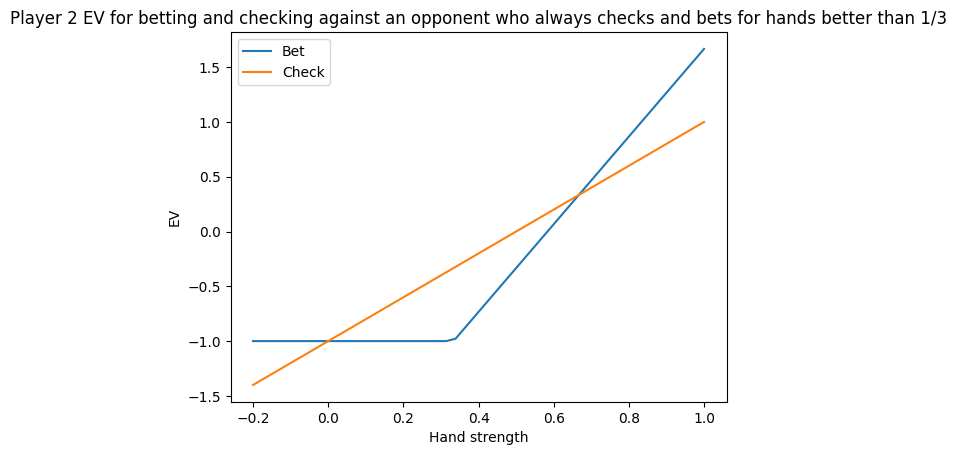

In [10]:
# what does this look like against an opp who always checks and bets for hands better than 1/3?
bet1_test = lambda x1: 0
call1_test = lambda x1 : 1 if x1 > 1/3 else 0

ev_func = get_p2_bet_check_evs(call1_test, bet1_test)
bet_ev = lambda x : ev_func(x)[0]
check_ev = lambda x : ev_func(x)[1]
x, y = sample(bet_ev, -.2, 1, 50)
plt.plot(x, y)
x, y = sample(check_ev, -0.2, 1, 50)
plt.plot(x, y)
plt.title("Player 2 EV for betting and checking against an opponent who always checks and bets for hands better than 1/3")
plt.xlabel("Hand strength")
plt.ylabel("EV")
plt.legend(["Bet", "Check"])
plt.show()



# should cross at x = 0 and 2/3

fold prob: 0.16666666666666669


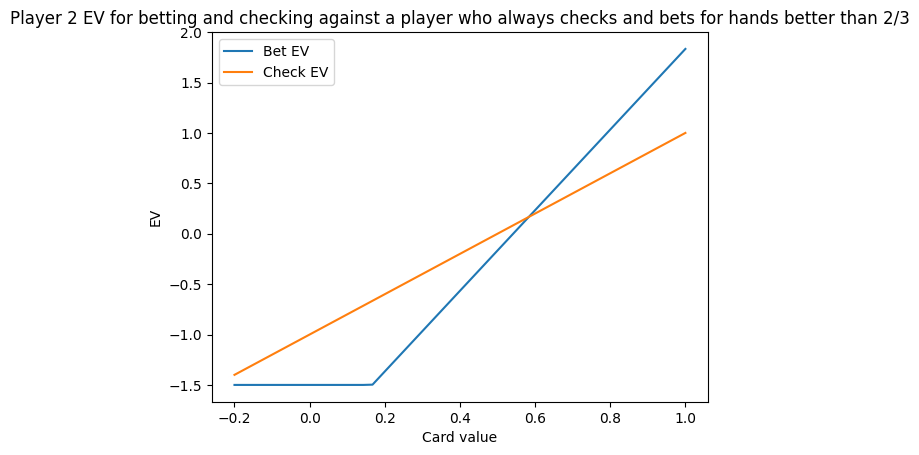

In [11]:
# what does this look like against an opp who always checks and bets for hands better than 2/3?
bet1_test = lambda x1: 0
call1_test = lambda x1 : 1 if x1 > 1/6 else 0

ev_func = get_p2_bet_check_evs(call1_test, bet1_test)
bet_ev = lambda x : ev_func(x)[0]
check_ev = lambda x : ev_func(x)[1]
x, y = sample(bet_ev, -.2, 1, 50)
plt.plot(x, y)
x, y = sample(check_ev, -0.2, 1, 50)
plt.plot(x, y)
# TODO: make titles and axes
# title
plt.title("Player 2 EV for betting and checking against a player who always checks and bets for hands better than 2/3")
plt.xlabel("Card value")
plt.ylabel("EV")
plt.legend(["Bet EV", "Check EV"])
plt.show()


# should cross at x = 0 and 2/3

To find the equilibrium, we can try iteratively finding best responses for either player. We can start with a random strategy for p1 and p2 and then iteratively update their strategies until they converge to an equilibrium.

In [12]:
# now, we have a call BR to a betting function and a betting function which gives a BR to a call function. 
# Iterate both until we reach equilibrium.
disc = functools.partial(discretize, start = 0, stop = 1, n=1000)
iters = 2
p1_bet_function = lambda x2: 0
seed_bet_function = lambda x2: 1 if x2 > 0.5 else 0
bet_funcs = [seed_bet_function]
call_funcs = [get_call_BR(disc(seed_bet_function))]
# for i in range(iters):
#     call_function = get_call_BR(disc(bet_funcs[-1]))
#     call_funcs.append(call_function)
#     bet_function = get_p2_bet_BR(disc(call_funcs[-1]), p1_bet_function)
#     bet_funcs.append(bet_function)


fold prob: 0.6251251113159848


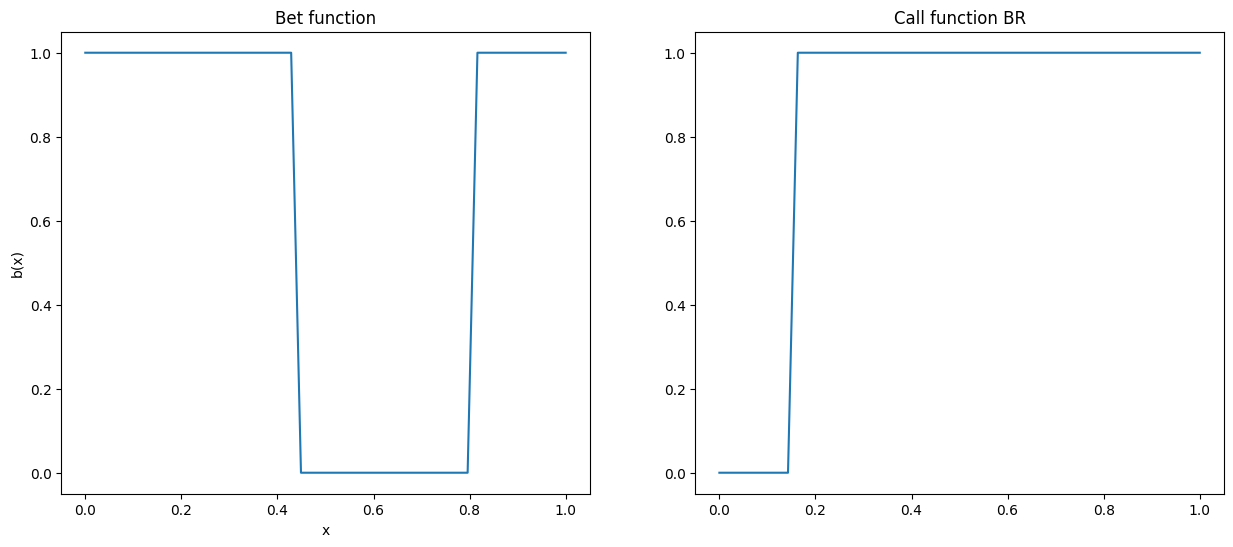

In [13]:

bet_function = get_p2_bet_BR(disc(call_funcs[-1]), p1_bet_function)
bet_funcs.append(bet_function)
call_function = get_call_BR(disc(bet_funcs[-1]))
call_funcs.append(call_function)

# plot
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

x, y = sample(bet_funcs[-1], 0, 1, 50)
axs[0].plot(x, y)
axs[0].set_title("Bet function")
axs[0].set_ylabel("b(x)")
axs[0].set_xlabel("x")

x, y = sample(call_funcs[-1], 0, 1, 50)
axs[1].plot(x, y)
axs[1].set_title("Call function BR")
plt.show()

It turns out that this gives two unstable strategies. 

* If Player 1 calls with hands above 0.17, then player 2 should bet with hands below 0.54 OR above 0.85.
* Player 1 should respond by calling with hands above 0.69.
* If Player 1 calls with hands above 0.69, then player 2 should bet with hands above 0.59.
* Player 1 should respond by calling with hands above 0.17.
...

This cycle continues indefinitely.

We can also show this by solving for the cutoffs which give the best response for either player.

This gives a function beta_BR which takes our current calling cutoff $\beta$ and returns the best response calling cutoff TO the best response for the opponent.

An equilibrium corresponds to a fixed point of this function, but this function has no fixed points.

We can also simplify the betting function to two cutoffs $\alpha$ and $\gamma$ such that player 1 bets with hands below $\alpha$ or above $\gamma$.


In [14]:
def find_fixed_point(function, seed_input, iters=100):
    # find the fixed point of a function using the seed_input
    # return the fixed point
    x = seed_input
    for i in range(iters):
        x = function(x)
    return x

In [15]:
def beta_BR(prev_beta):
    if prev_beta < 1/3:
        return 3/8 * prev_beta + 5/8
    elif prev_beta < 2/5:
        return 1 - 3/4 * prev_beta
    else:
        return 1/4 * prev_beta
    
def alpha_gamma_BR(beta):
    print(beta)
    alpha = max(0, 0.5 * (3*beta - 1))
    gamma = 0.5 * (beta + 1)
    return alpha, gamma
    
find_fixed_point(beta_BR, random.random(), 100)
# sometimes gives 0.1724137931034483, sometimes 0.6896551724137931

0.6896551724137931

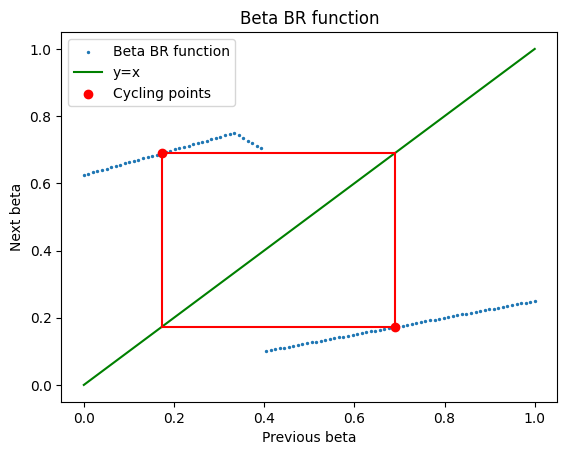

In [16]:
r1 = 0.1724137931034483
r2 = 0.6896551724137931

# plot the function and show the two cycling points
x = np.linspace(0, 1, 100)
y = np.array([beta_BR(i) for i in x])
plt.scatter(x, y, s=2, label="Beta BR function")
plt.plot(x, x, color='green', label='y=x')
plt.scatter([r1, r2], [beta_BR(r1), beta_BR(r2)], color='red', label="Cycling points")
plt.plot([r1, r2], [beta_BR(r1), beta_BR(r1)], color='red')
plt.plot([r1, r2], [beta_BR(r2), beta_BR(r2)], color='red')
plt.plot([r1, r1], [beta_BR(r1), beta_BR(r2)], color='red')
plt.plot([r2, r2], [beta_BR(r1), beta_BR(r2)], color='red')
plt.title("Beta BR function")
plt.xlabel("Previous beta")
plt.ylabel("Next beta")
plt.legend()
plt.show()

0.1724137931034483
0.6896551724137931
r1: 0.1724137931034483, alpha: 0, gamma: 0.5862068965517242
r2: 0.6896551724137931, alpha: 0.5344827586206897, gamma: 0.8448275862068966


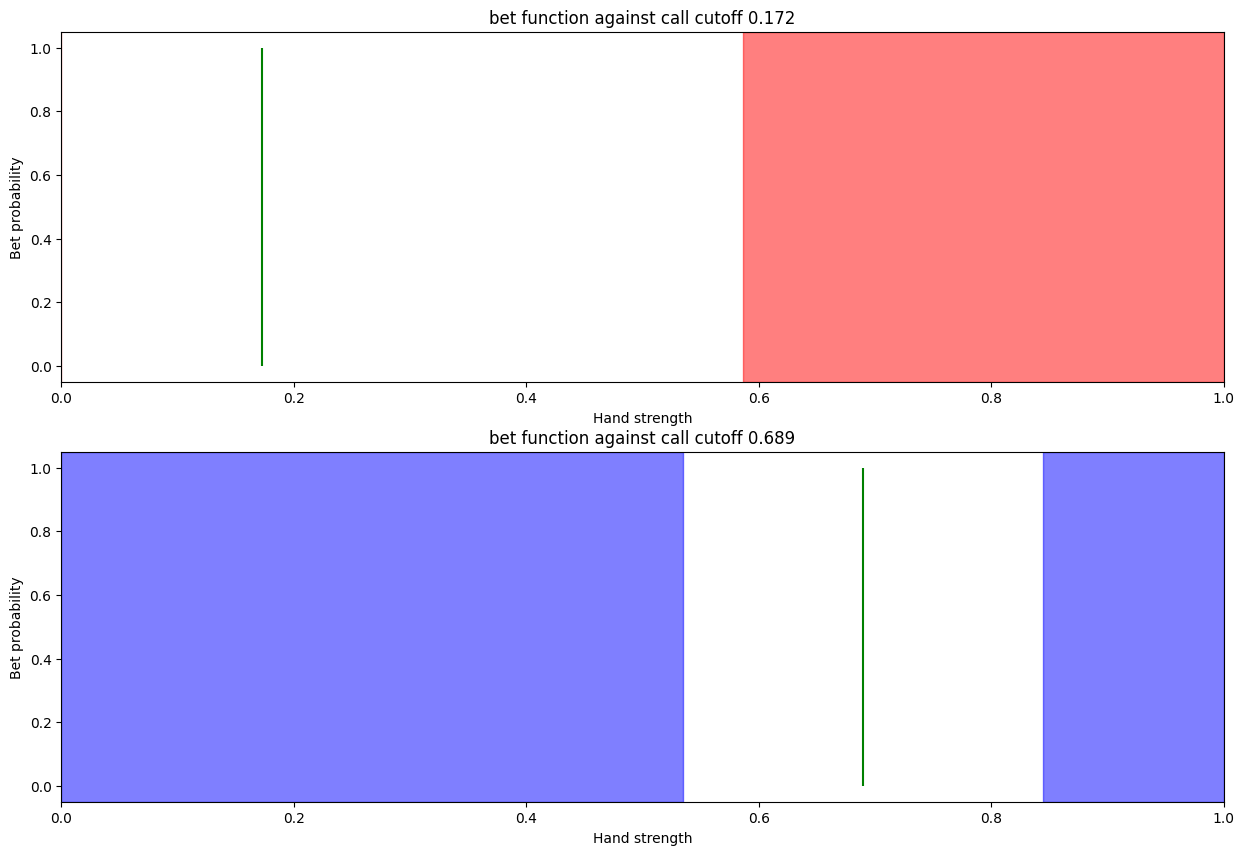

In [17]:
# show the betting functions corresponding to these two fixed points
alpha_r1, gamma_r1 = alpha_gamma_BR(r1)
alpha_r2, gamma_r2 = alpha_gamma_BR(r2)
print(f"r1: {r1}, alpha: {alpha_r1}, gamma: {gamma_r1}")
print(f"r2: {r2}, alpha: {alpha_r2}, gamma: {gamma_r2}")

fig, axs = plt.subplots(2, 1, figsize=(15, 10))
axs[0].set_xlim(0, 1)
axs[1].set_xlim(0, 1)
axs[0].vlines(r1, 0, 1, color='green', label="Cycling point")
axs[1].vlines(r2, 0, 1, color='green', label="Cycling point")
axs[0].axvspan(gamma_r1, plt.xlim()[1], color='red', alpha=0.5)
axs[0].axvspan(plt.xlim()[0], alpha_r1, color='red', alpha=0.5)
axs[1].axvspan(gamma_r2, plt.xlim()[1], color='blue', alpha=0.5)
axs[1].axvspan(plt.xlim()[0], alpha_r2, color='blue', alpha=0.5)

axs[0].set_title("bet function against call cutoff 0.172")
axs[1].set_title("bet function against call cutoff 0.689")
axs[0].set_xlabel("Hand strength")
axs[0].set_ylabel("Bet probability")
axs[1].set_xlabel("Hand strength")
axs[1].set_ylabel("Bet probability")
plt.show()

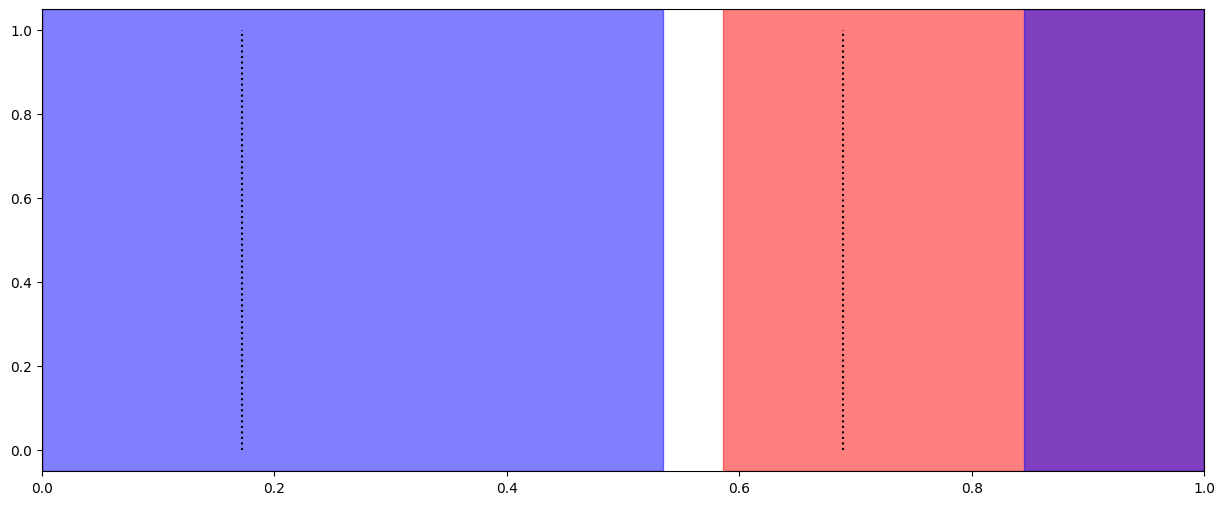

In [18]:
# plot them together.
fig, axs = plt.subplots(1, 1, figsize=(15, 6))
axs.set_xlim(0, 1)
axs.vlines(r1, 0, 1, color='black', linestyles='dotted', label="Cycling point 1")
axs.vlines(r2, 0, 1, color='black', linestyles='dotted', label="Cycling point 2")
axs.axvspan(gamma_r1, plt.xlim()[1], color='red', alpha=0.5)
axs.axvspan(plt.xlim()[0], alpha_r1, color='red', alpha=0.5)
axs.axvspan(gamma_r2, plt.xlim()[1], color='blue', alpha=0.5)
axs.axvspan(plt.xlim()[0], alpha_r2, color='blue', alpha=0.5)

In [75]:
def get_bet_payoff(call_function, x):
    # get the ev of payoff for the bettor by betting with this hand strength
    return 1 + 4 * integral(call_function, 0, x) - 3 * integral(call_function, 0, 1)

def get_check_payoff(call_function, x):
    return 2*x-1

def get_bettor_payoff(bet_function, call_function, x):
    action = bet_function(x)
    return action * get_bet_payoff(call_function, x) + (1-action) * get_check_payoff(call_function, x)

def get_bet_gain(call_function, x):
    # get the ev that the betting player gains by betting with this hand strength
    return get_bet_payoff(call_function, x) - get_check_payoff(call_function, x)

def get_call_payoff(bet_function, x):
    # get the ev of payoff for the caller by calling with this hand strength
    return 4 * integral(bet_function, 0, x) / integral(bet_function, 0, 1) - 2

def get_fold_payoff(bet_function, x):
    return -1

def get_caller_payoff(bet_function, call_function, x):
    # get the caller's expected payoff from a given hand strength
    # include the payoff from calling and folding AND the payoff we might get from winning a check-showdown
    action = call_function(x)
    p_bet = integral(bet_function, 0, 1)
    p_check_win = x - integral(bet_function, 0, x)
    p_check_lose = 1-x - integral(bet_function, x, 1)
    return p_check_win - p_check_lose + action * p_bet * get_call_payoff(bet_function, x) + (1-action) * p_bet *  get_fold_payoff(bet_function, x)

def get_call_gain(bet_function, x):
    # get the ev that the calling player gains by calling with this hand strength
    return get_call_payoff(bet_function, x) - get_fold_payoff(bet_function, x)

def get_bet_BR(call_function, indifference_response=lambda x : 0.5):
    # get the best response to a call function
    # if the gain is 0, return the indifference response, which is a function of x
    def BR(x):
        gain = get_bet_gain(call_function, x)
        if np.isclose(gain, 0, atol=1e-3):
            return indifference_response(x)
        elif gain < 0:
            return 0
        else:
            return 1
    return BR

def get_call_BR(bet_function, indifference_response=lambda x : 0.5):
    # get the best response to a bet function
    # if the gain is 0, return the indifference response, which is a function of x
    def BR(x):
        gain = get_call_gain(bet_function, x)
        if np.isclose(gain, 0, atol=1e-3):
            return indifference_response(x)
        elif gain < 0:
            return 0
        else:
            return 1
    return BR

/var/folders/b1/z91xjqp97qb1ts5z67d5h7f00000gn/T/ipykernel_92462/2117760926.py:18: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(function, start, stop)[0]


Bettor original EV: 0.10000244072779446
Caller original EV: -0.10000396438602263
Bettor BR EV: 0.09996505626353953
Caller EV vs BR: -0.09996261660856934
Caller BR EV: -0.1000043140167506
Bettor EV vs BR: 0.10000000015900865


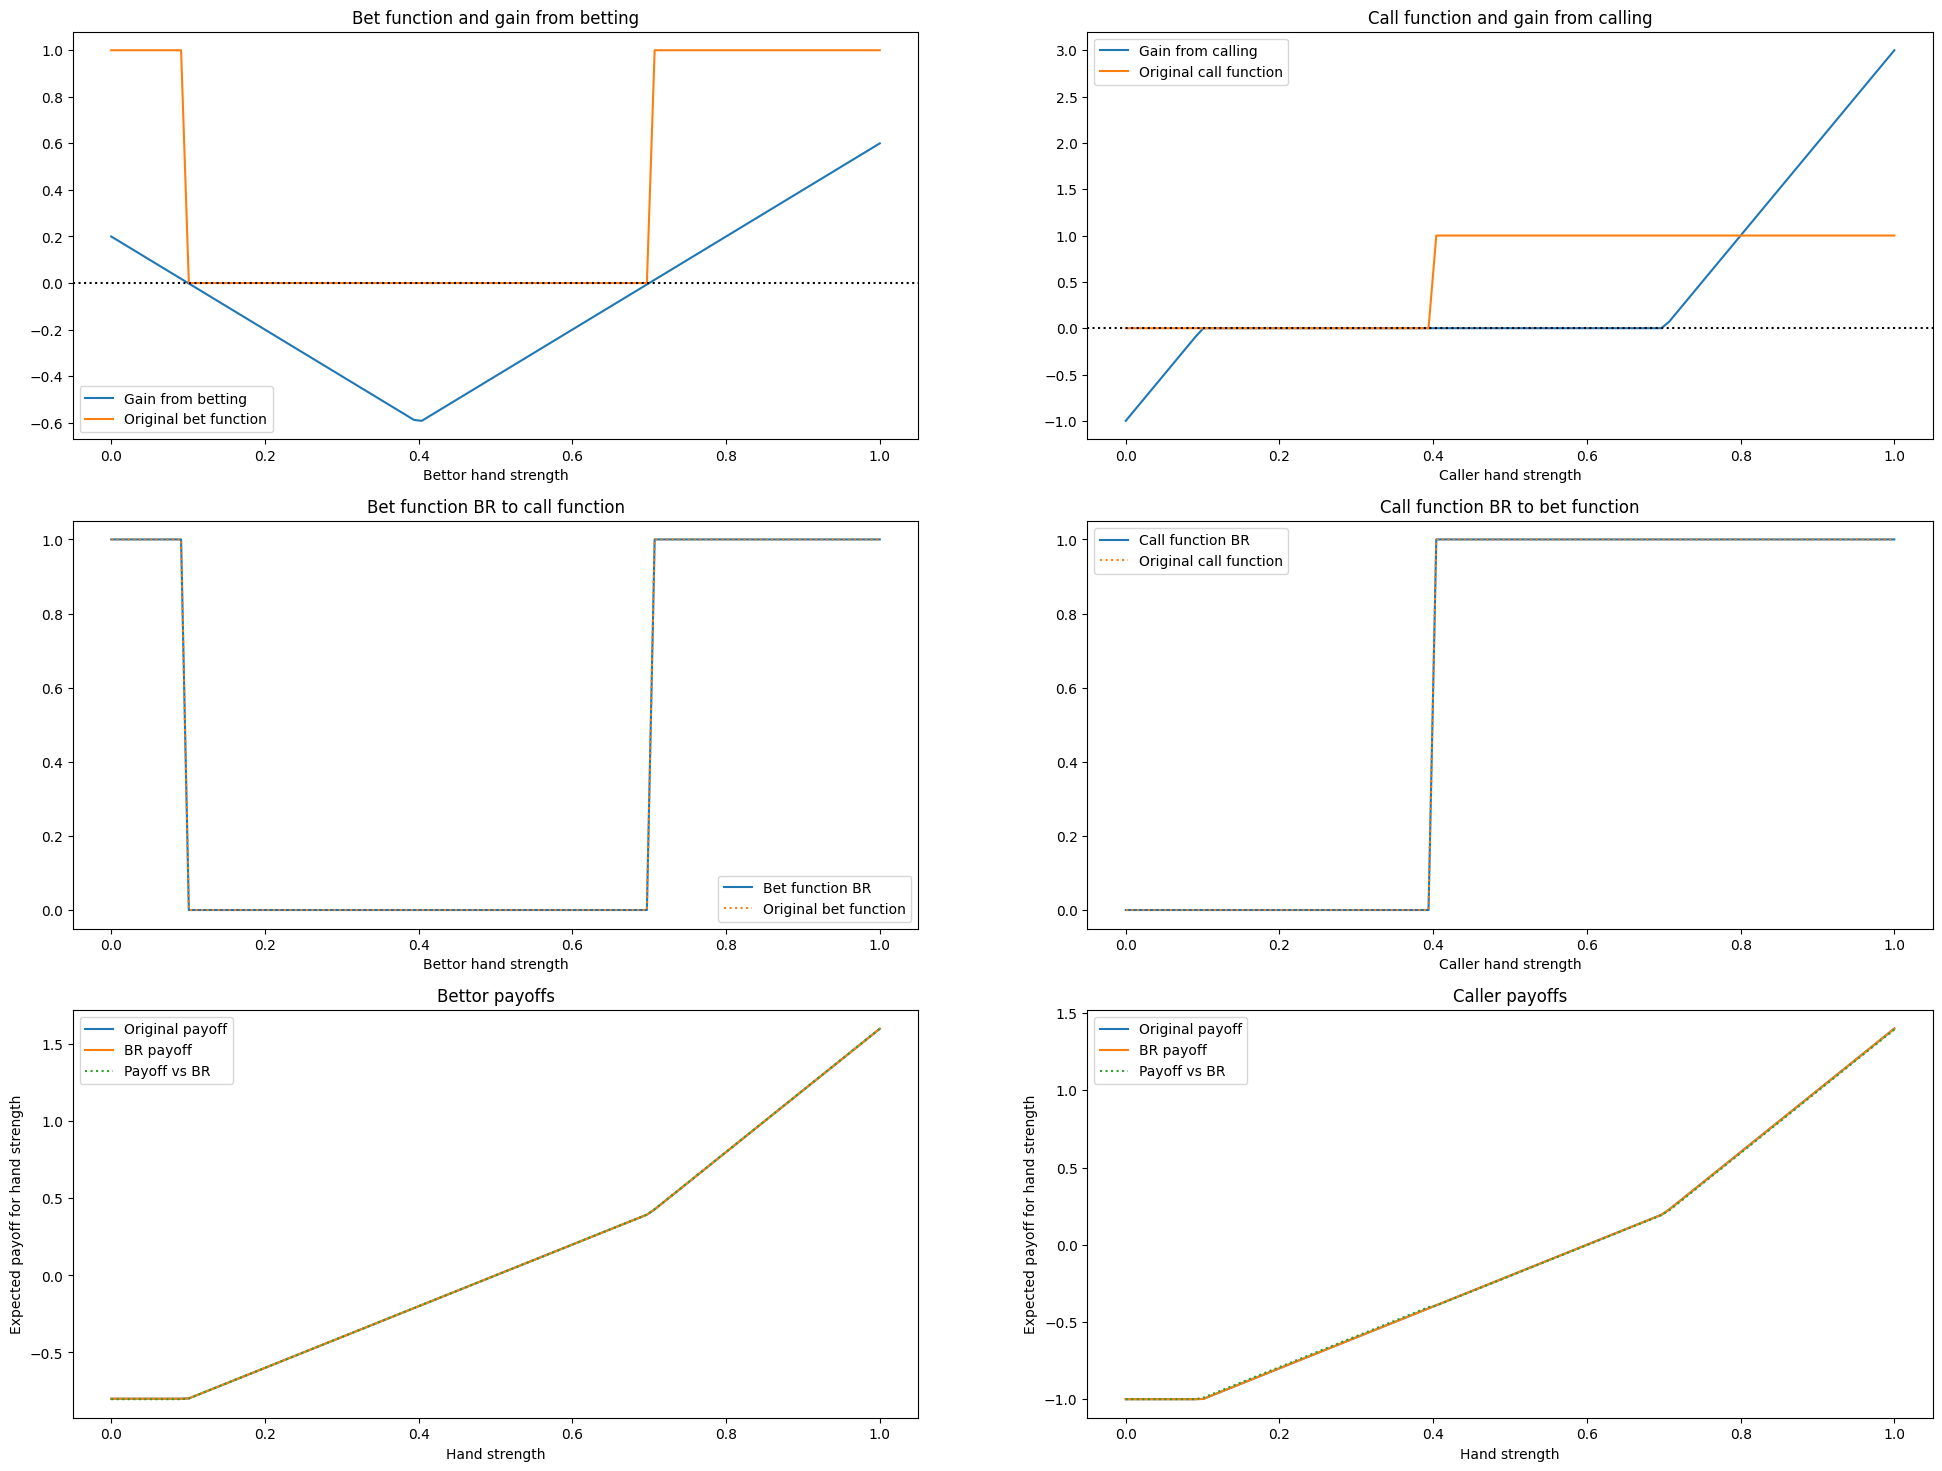

In [108]:
def response_and_payoff_plots(bet_function, call_function, bet_indifference_function, call_indifference_function):
    X = np.linspace(0, 1, 100)

    bet_BR = discretize(get_bet_BR(call_function, indifference_response=bet_indifference_function), 0, 1, 100)
    call_BR = discretize(get_call_BR(bet_function, indifference_response=call_indifference_function), 0, 1, 100)

    bets = [bet_function(x) for x in X]
    calls = [call_function(x) for x in X]
    bettor_original_payoffs = [get_bettor_payoff(bet_function, call_function, x) for x in X]
    bettor_BR_payoffs = [get_bettor_payoff(bet_BR, call_function, x) for x in X]
    bettor_payoffs_vs_BR = [get_bettor_payoff(bet_function, call_BR, x) for x in X]
    caller_original_payoffs = [get_caller_payoff(bet_function, call_function, x) for x in X]
    caller_BR_payoffs = [get_caller_payoff(bet_function, call_BR, x) for x in X]
    caller_payoffs_vs_BR = [get_caller_payoff(bet_BR, call_function, x) for x in X]
    bet_gains = [get_bet_gain(call_function, x) for x in X]
    call_gains = [get_call_gain(bet_function, x) for x in X]

    bet_BRs = [bet_BR(x) for x in X]
    call_BRs = [call_BR(x) for x in X]

    fig, axs = plt.subplots(3, 2, figsize=(24, 18))
    axs[0][0].plot(X, bet_gains)
    axs[0][0].plot(X, bets)
    axs[0][0].set_title("Bet function and gain from betting")
    axs[0][0].set_xlabel("Bettor hand strength")
    axs[0][0].legend(["Gain from betting", "Original bet function"])
    axs[0][0].axhline(0, color='black', linestyle='dotted')

    axs[1][0].plot(X, bet_BRs)
    axs[1][0].plot(X, bets, linestyle='dotted')
    axs[1][0].set_xlabel("Bettor hand strength")
    axs[1][0].set_title("Bet function BR to call function")
    axs[1][0].legend(["Bet function BR", "Original bet function"])

    axs[0][1].plot(X, call_gains)
    axs[0][1].plot(X, calls)
    axs[0][1].set_title("Call function and gain from calling")
    axs[0][1].set_xlabel("Caller hand strength")
    axs[0][1].legend(["Gain from calling", "Original call function"])
    axs[0][1].axhline(0, color='black', linestyle='dotted')

    axs[1][1].plot(X, call_BRs)
    axs[1][1].plot(X, calls, linestyle='dotted')
    axs[1][1].set_title("Call function BR to bet function")
    axs[1][1].set_xlabel("Caller hand strength")
    axs[1][1].legend(["Call function BR", "Original call function"])

    axs[2][0].plot(X, bettor_original_payoffs)
    axs[2][0].plot(X, bettor_BR_payoffs)
    axs[2][0].plot(X, bettor_payoffs_vs_BR, linestyle='dotted')
    axs[2][0].set_title("Bettor payoffs")
    axs[2][0].set_xlabel("Hand strength")
    axs[2][0].set_ylabel("Expected payoff for hand strength")
    axs[2][0].legend(["Original payoff", "BR payoff", "Payoff vs BR"])

    axs[2][1].plot(X, caller_original_payoffs)
    axs[2][1].plot(X, caller_BR_payoffs)
    axs[2][1].plot(X, caller_payoffs_vs_BR, linestyle='dotted')
    axs[2][1].set_title("Caller payoffs")
    axs[2][1].set_xlabel("Hand strength")
    axs[2][1].set_ylabel("Expected payoff for hand strength")
    axs[2][1].legend(["Original payoff", "BR payoff", "Payoff vs BR"])

    ev_bettor = integral(lambda x : get_bettor_payoff(bet_function, call_function, x), 0, 1)
    ev_caller = integral(lambda x : get_caller_payoff(bet_function, call_function, x), 0, 1)
    ev_bettor_BR = integral(lambda x : get_bettor_payoff(bet_BR, call_function, x), 0, 1)
    ev_caller_vs_BR = integral(lambda x : get_caller_payoff(bet_BR, call_function, x), 0, 1)
    ev_caller_BR = integral(lambda x : get_caller_payoff(bet_function, call_BR, x), 0, 1)
    ev_bettor_vs_BR = integral(lambda x : get_bettor_payoff(bet_function, call_BR, x), 0, 1)

    print(f"Bettor original EV: {ev_bettor}")
    print(f"Caller original EV: {ev_caller}")
    print(f"Bettor BR EV: {ev_bettor_BR}")
    print(f"Caller EV vs BR: {ev_caller_vs_BR}")
    print(f"Caller BR EV: {ev_caller_BR}")
    print(f"Bettor EV vs BR: {ev_bettor_vs_BR}")

alpha = 0.1
beta = 0.7
bet_indifference_function = lambda x : 0
call_indifference_function = lambda x : 1 if x > beta/2 + alpha/2 else 0
bet_function = lambda x : 1 if x < alpha or x > beta else bet_indifference_function(x)
call_function = lambda x : 0 if x < alpha else (1 if x > beta else call_indifference_function(x))
response_and_payoff_plots(bet_function, call_function, bet_indifference_function, call_indifference_function)

Using a slightly different strategy for the caller, where they call 0.4 instead of 0.5 when indifferent, is no longer an equilibrium because the bettor will now bluff more often and check some stronger hands.
Why does the caller care? Because this new BR from the bettor gives a lower payoff for the caller, so this is not a security strategy for the caller.
Playing any strategy described in our equilibrium is a security strategy, so the caller should stick to this.

/var/folders/b1/z91xjqp97qb1ts5z67d5h7f00000gn/T/ipykernel_92462/2117760926.py:18: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(function, start, stop)[0]


Bettor original EV: 0.09999929425939914
Caller original EV: -0.10000275890110404
Bettor BR EV: 0.14138487434268657
Caller EV vs BR: -0.14138511193688186
Caller BR EV: -0.10003782551081082
Bettor EV vs BR: 0.10003383492187311


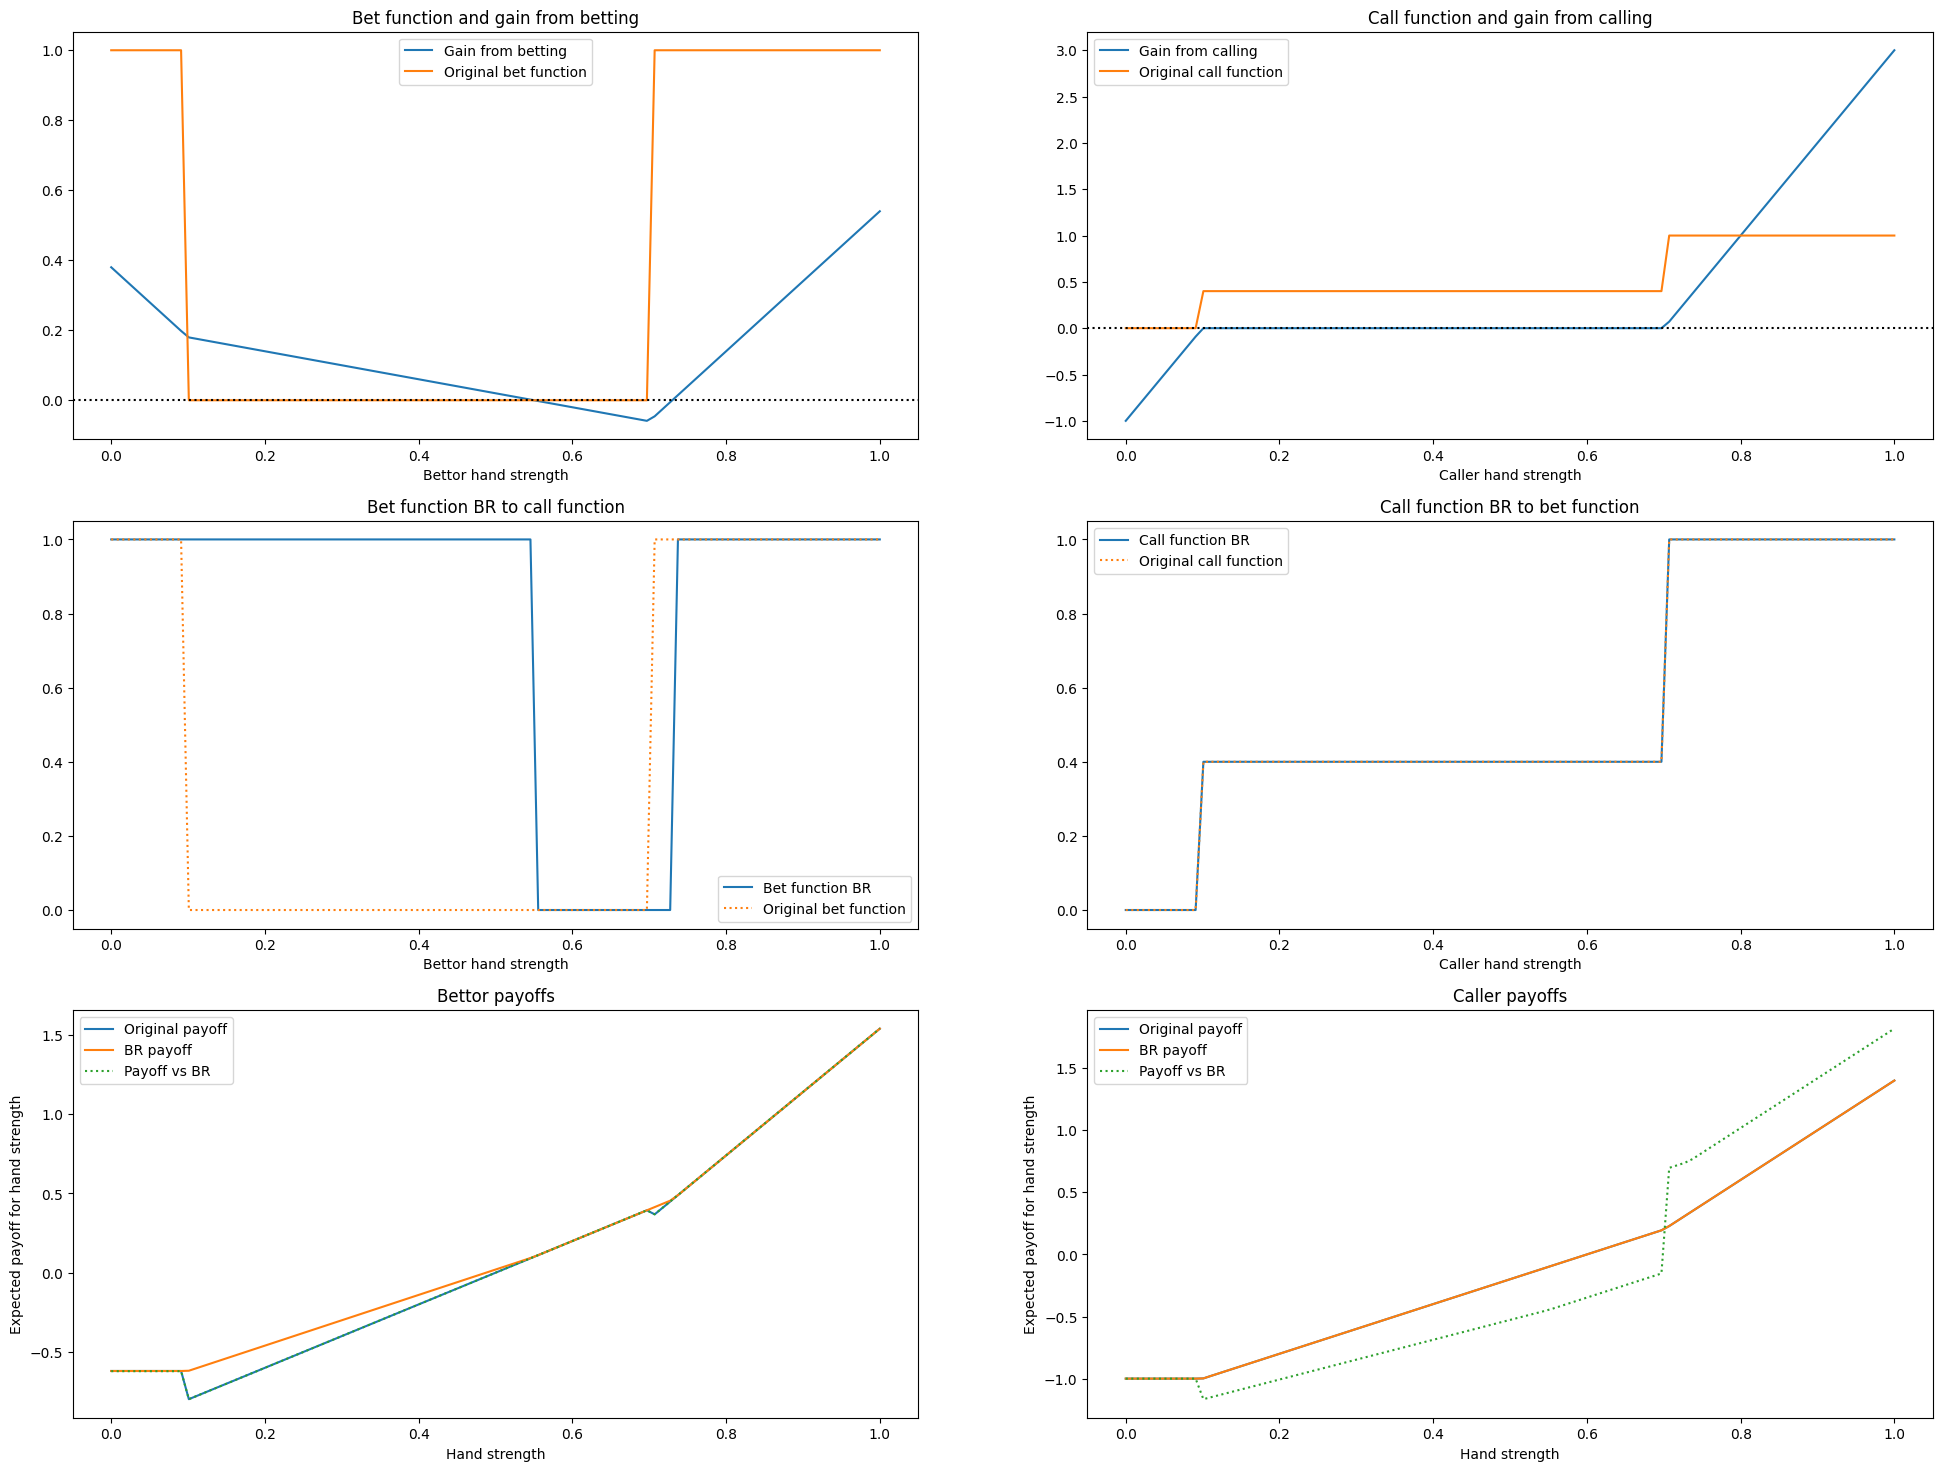

In [104]:
alpha = 0.1
beta = 0.7
bet_indifference_function = lambda x : 0
call_indifference_function = lambda x : 0.4
bet_function = lambda x : 1 if x < alpha or x > beta else bet_indifference_function(x)
call_function = lambda x : 0 if x < alpha else (1 if x > beta else call_indifference_function(x))
response_and_payoff_plots(bet_function, call_function, bet_indifference_function, call_indifference_function)

## Iteration and Dynamics

In [199]:
class discretized_strategy:
    def __init__(self, function=None, n=None, values=None):
        if function is not None:
            assert values is None, (f"Cannot provide both a function and values to a discretized strategy")
            if n is None:
                n = 1000
            self.X, self.values = sample(function, 0, 1, n)
        else:
            assert values is not None, (f"Must provide either a function or values to a discretized strategy")
            if n is None:
                n = len(values)
            else:
                assert n == len(values), (f"Values must be the same length as n")
            self.n=n    
            self.values = values
            self.X = np.linspace(0, 1, n)

    def integrate(self, start, stop):
        return integral_simps(self.X, self.values, start, stop)

    def get_action(self, x):
        return np.interp(x, self.X, self.values)
    
class bettor_strategy(discretized_strategy):
    def get_call_payoff(self, x):
        # the ev of calling against this strategy with a given hand strength
        return 4 * self.integrate(0, x) / self.integrate(0, 1) - 2
    
    def get_fold_payoff(self, x):
        # the ev of folding against this strategy with a given hand strength
        return -1
    
    def get_call_gain(self, x):
        # get the ev that the calling player gains by calling with this hand strength
        return self.get_call_payoff(x) - self.get_fold_payoff(x)
    
    def get_caller_BR(self):
        # get the best response to this strategy
        actions = []
        for x in self.X:
            call_gain = self.get_call_payoff(x) - self.get_fold_payoff(x)
            if np.isclose(call_gain, 0, atol=1e-3):
                actions.append(0.5) # TODO: add some way to customize the indifference response
            elif call_gain < 0:
                actions.append(0)
            else:
                actions.append(1)
        return caller_strategy(values=actions)
    
    def get_hand_ev_against(self, x, caller):
        # get the EV of a hand with a given strength against a given caller strategy
        action = self.get_action(x)
        return action * caller.get_bet_payoff(x) + (1-action) * caller.get_check_payoff(x)
    
    def get_ev_against(self, caller):
        # get the EV of this strategy against a given caller (with a random hand)
        return integral_simps(self.X, [self.get_hand_ev_against(x, caller) for x in self.X], 0, 1)

class caller_strategy(discretized_strategy):
    def get_bet_payoff(self, x):
        # the ev of betting against this strategy with a given hand strength
        return 1 + 4 * self.integrate(0, x) - 3 * self.integrate(0, 1)
    
    def get_check_payoff(self, x):
        # the ev of checking against this strategy with a given hand strength
        return 2*x-1
    
    def get_bet_gain(self, x):
        # get the ev that the betting player gains by betting with this hand strength
        return self.get_bet_payoff(x) - self.get_check_payoff(x)

    def get_bettor_BR(self):
        # get the best response to this strategy
        actions = []
        for x in self.X:
            bet_gain = self.get_bet_payoff(x) - self.get_check_payoff(x)
            if np.isclose(bet_gain, 0, atol=1e-3):
                actions.append(0.5)
            elif bet_gain < 0:
                actions.append(0)
            else:
                actions.append(1)
        return bettor_strategy(values=actions)
    
    def get_hand_ev_against(self, x, bettor):
        # get the EV of a hand with a given strength against a given bettor strategy
        action = self.get_action(x)
        p_bet = bettor.integrate(0, 1)
        p_check_win = x - bettor.integrate(0, x)
        p_check_lose = 1-x - bettor.integrate(x, 1)
        return p_check_win - p_check_lose + action * p_bet * bettor.get_call_payoff(x) + (1-action) * p_bet *  bettor.get_fold_payoff(x)
    
    def get_ev_against(self, bettor):
        # get the EV of this strategy against a given bettor (with a random hand)
        return integral_simps(self.X, [self.get_hand_ev_against(x, bettor) for x in self.X], 0, 1)

In [192]:
def iterate_simultaneous(seed_bettor, seed_caller, iters, plot=False):
    bettor = seed_bettor
    caller = seed_caller
    if plot:
        fig, axs = plt.subplots(iters, 2, figsize=(25, 5*iters))
    for i in range(iters):
        caller_BR = bettor.get_caller_BR()
        bettor_BR = caller.get_bettor_BR()
        if plot:
            plot_strategies(axs[i][0], axs[i][1], bettor, caller)
        bettor = bettor_BR
        caller = caller_BR
    return caller, bettor

def plot_strategies(ax1, ax2, bettor : bettor_strategy, caller : caller_strategy):
    '''
    for a bettor and caller strategy, plot the strategies and best responses to each other, along with the gain from calling/betting with a given hand strength.
    '''
    caller_BR = bettor.get_caller_BR()
    bettor_BR = caller.get_bettor_BR()

    ax1.plot(bettor.X, bettor.values)
    ax1.plot(bettor_BR.X, bettor_BR.values, linestyle='dotted')
    ax1.plot(bettor.X, [caller.get_bet_gain(x) for x in bettor.X])
    ax1.hlines(0, 0, 1, color='black', linestyle='dotted')
    ax1.set_title("Bettor strategy and best response to caller")
    ax1.set_xlabel("Hand strength")
    ax1.set_ylabel("Bet probability")
    ax1.legend(["Original strategy", "BR to caller", "EV gain from betting"])

    ax2.plot(caller.X, caller.values)
    ax2.plot(caller_BR.X, caller_BR.values, linestyle='dotted')
    ax2.plot(caller.X, [bettor.get_call_gain(x) for x in caller.X])
    ax2.hlines(0, 0, 1, color='black', linestyle='dotted')
    ax2.set_title("Caller strategy and best response to bettor")
    ax2.set_xlabel("Hand strength")
    ax2.set_ylabel("Bet probability")
    ax2.legend(["Original strategy", "BR to bettor", "EV gain from calling"])

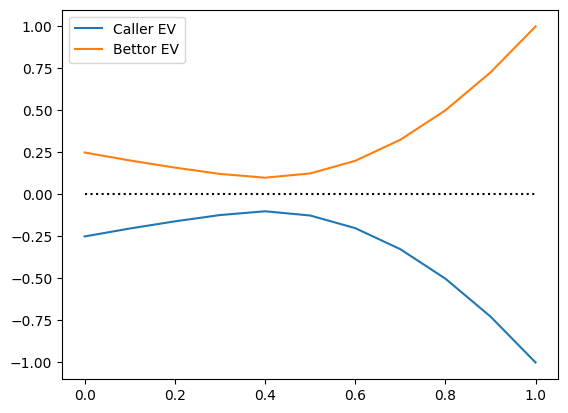

In [225]:
# for various values of the caller cutoff, find the EV the caller gets against the bettors BR to their strategy
# notice this is maximized at 0.4, which is the security strategy for the caller!
cutoffs = np.linspace(0, 1, 11)
caller_evs = []
bettor_evs = []
for c in cutoffs:
    caller = caller_strategy(function=lambda x : 1 if x > c else 0)
    bettor = caller.get_bettor_BR()
    caller_ev = caller.get_ev_against(bettor)
    bettor_ev = bettor.get_ev_against(caller)
    caller_evs.append(caller_ev)
    bettor_evs.append(bettor_ev)
plt.plot(cutoffs, caller_evs)
plt.plot(cutoffs, bettor_evs)
plt.legend(["Caller EV", "Bettor EV"])
plt.hlines(0, 0, 1, color='black', linestyle='dotted')

In [216]:
# for various values of the bettor cutoffs, find the EV the bettor gets against the callers BR to their strategy
n = 11
alphas = np.linspace(0, 1, n)
betas = np.linspace(0, 1, n)

caller_evs = np.zeros((n, n))
bettor_evs = np.zeros((n, n))
for i, a in enumerate(alphas):
    for j, b in enumerate(betas):
        if beta > alpha and (alpha > 0 or beta < 1):
            bettor = bettor_strategy(function=lambda x : 1 if x < a or x > b else 0)
            caller = bettor.get_caller_BR()
            caller_ev = caller.get_ev_against(bettor)
            bettor_ev = bettor.get_ev_against(caller)
            caller_evs[i][j] = caller_ev
            bettor_evs[i][j] = bettor_ev

/var/folders/b1/z91xjqp97qb1ts5z67d5h7f00000gn/T/ipykernel_92462/550115975.py:27: RuntimeWarning: invalid value encountered in scalar divide
  return 4 * self.integrate(0, x) / self.integrate(0, 1) - 2


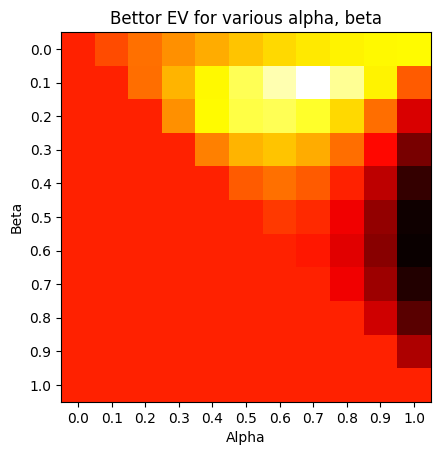

In [224]:
plt.imshow(bettor_evs, cmap='hot')
plt.xlabel("Alpha")
plt.ylabel("Beta")
plt.xticks(range(0, n), np.round(betas, 1))
plt.yticks(range(0, n), np.round(alphas, 1))
plt.title("Bettor EV for various alpha, beta against caller BR")
plt.show()

In [226]:
# for various values of the bettor cutoffs, find the EV the bettor gets against the nash equilibrium caller
n = 11
caller = caller_strategy(function=lambda x : 1 if x>0.4 else 0)
alphas = np.linspace(0, 1, n)
betas = np.linspace(0, 1, n)

# caller_evs = np.zeros((n, n))
bettor_evs = np.zeros((n, n))
for i, a in enumerate(alphas):
    for j, b in enumerate(betas):
        if beta > alpha and (alpha > 0 or beta < 1):
            bettor = bettor_strategy(function=lambda x : 1 if x < a or x > b else 0)
            # caller_ev = caller.get_ev_against(bettor)
            bettor_ev = bettor.get_ev_against(caller)
            # caller_evs[i][j] = caller_ev
            bettor_evs[i][j] = bettor_ev

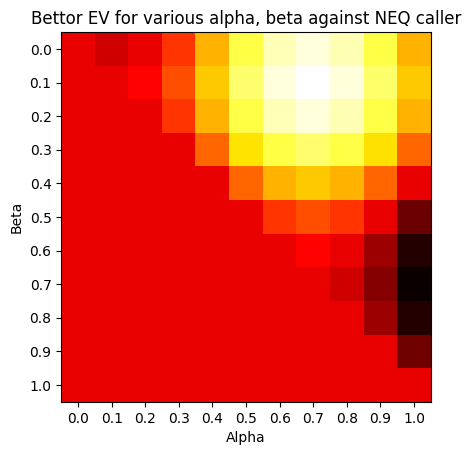

In [227]:
plt.imshow(bettor_evs, cmap='hot')
plt.xlabel("Alpha")
plt.ylabel("Beta")
plt.xticks(range(0, n), np.round(betas, 1))
plt.yticks(range(0, n), np.round(alphas, 1))
plt.title("Bettor EV for various alpha, beta against NEQ caller")
plt.show()

(<__main__.caller_strategy at 0x311bd3090>,
 <__main__.bettor_strategy at 0x312a55e50>)

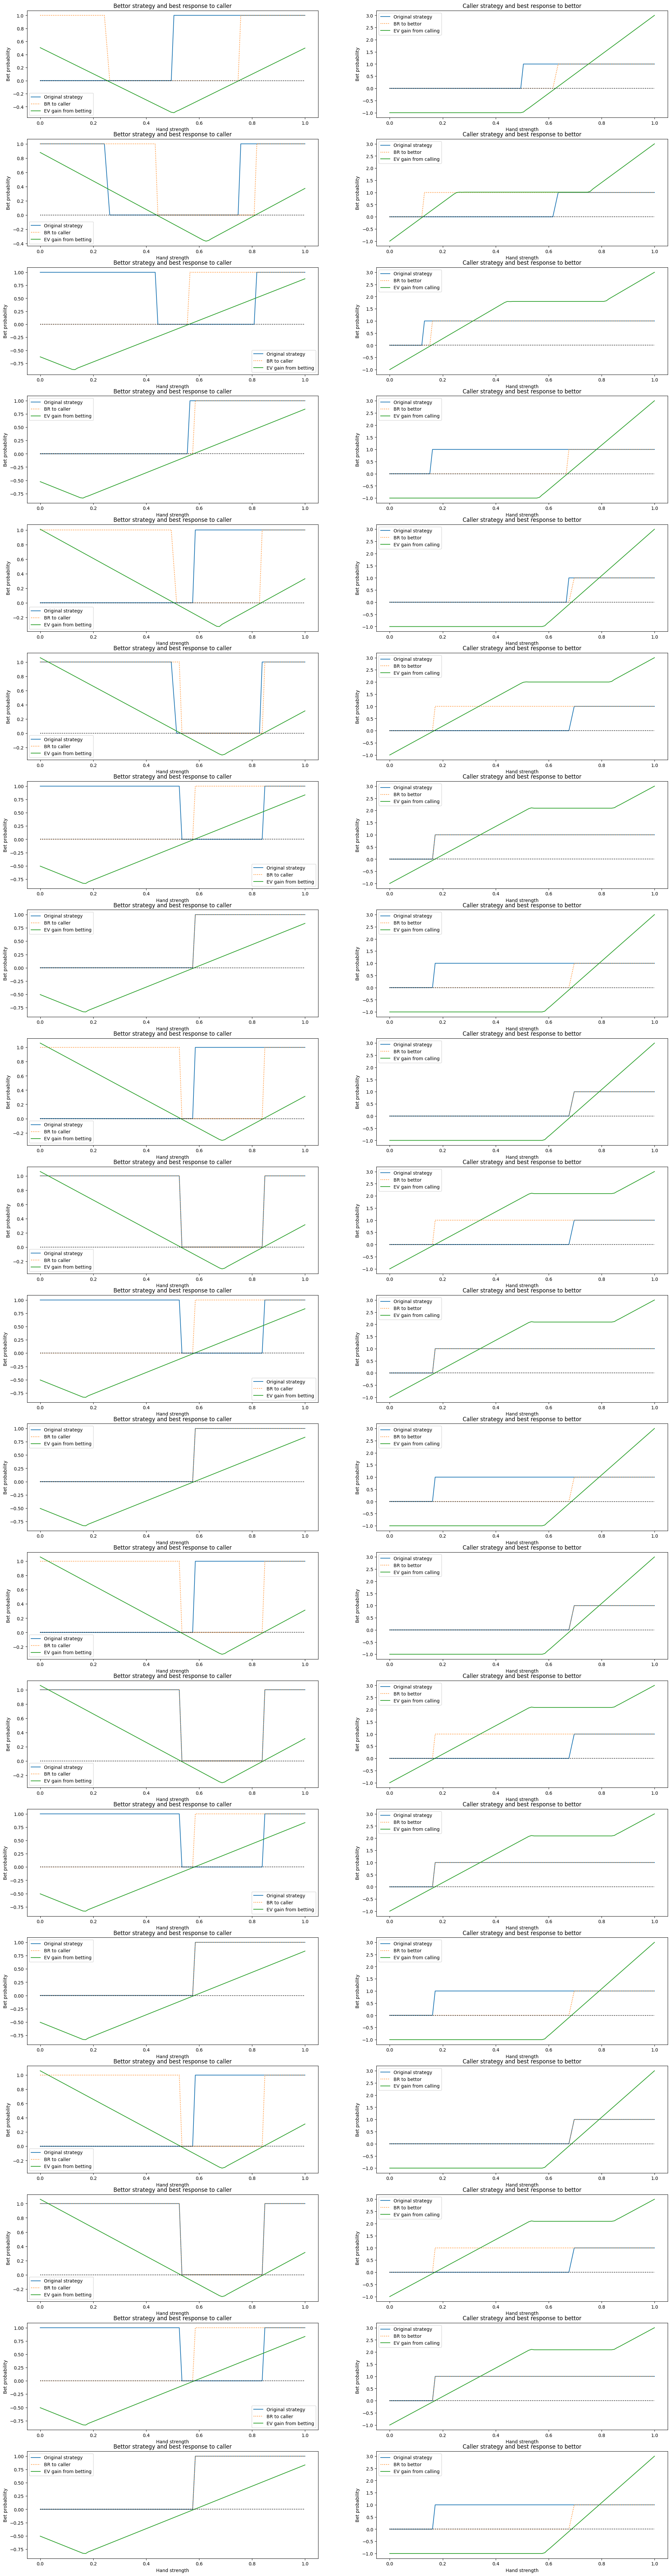

In [195]:
bettor_strat = bettor_strategy(function=lambda x : 1 if x > 0.5 else 0, n=100)
caller_strat = caller_strategy(function=lambda x : 1 if x > 0.5 else 0, n=100)
iterate_simultaneous(bettor_strat, caller_strat, 20, plot=True)

# this never converges, and wont find the nash equilibrium.
# the problem is that both players are trying to fully exploit the opponent, rather than playing a strategy which minimizes its own exploitability.

## IDEAS:
* three person poker variant - complicated, very computationally intensive
* n person poker variant
* brownian motion game, evolving hand strengths and possibilities for opponents hand strengths
* hand strengths are given as a private distribution to each player and variance is lowered after each betting round (perhaps a set of random finite hand strengths, with one removed each turn?)
* dynamics of responses and equilibriums - https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=a0def6517d5b67851fda2138aec9f35b7dbd65eb
